In [32]:
import cv2
import utils
import matplotlib.pyplot as plt
inputs = []
targets = []
image = cv2.imread("/Users/phamminhtuan/Downloads/Trainning_SET/Images/IMG_1590_iter_0.jpg")
labels, coords = utils.read_file_to_tensors("/Users/phamminhtuan/Downloads/Trainning_SET/Labels/IMG_1590_iter_0.txt")
for i, coord in enumerate(coords):
    x1, y1, x2, y2 = utils.find_yolov8_square(image, coord)
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
cv2.imwrite("/Users/phamminhtuan/Desktop/AIChallenge/avg_coords.jpg", image)

True

# Dataset

In [21]:
import torch
from torchvision import transforms
class MyDataset(torch.utils.data.Dataset):
    """
    Initializes the dataset by reading the image and label files, and processes them into tensors.

    Args:
        image_path (str): Path to the input image.
        label_path (str): Path to the label file (YOLO format).

    The method reads the image from the specified path and the label data, then processes each labeled 
    bounding box to crop and transform the image into a tensor. The processed tensors and corresponding 
    labels are stored in `self.inputs` and `self.targets` respectively.
    """
    def __init__(self, image_path, label_path):
        super().__init__()
        
        self.image_path = image_path
        self.label_path = label_path
        self.inputs, self.targets = [], []
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((32, 32))
        ])
        image = cv2.imread(self.image_path)
        labels, coords = utils.read_file_to_tensors(self.label_path)
        for i, coord in enumerate(coords):
            square = utils.find_yolov8_square(image, coord)
            cropped_image = utils.get_box(image, square)
            cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
            cropped_tensor = self.transform(cropped_image)
            self.inputs.append(cropped_tensor)
            self.targets.append(labels[i])
    def __getitem__(self, idx):
        image = self.inputs[idx]
        label = self.targets[idx]
        return image, label
    def __len__(self):
        return len(self.inputs)

In [49]:
import os
image_folder = "/Users/phamminhtuan/Downloads/Trainning_SET/Images"
label_folder = "/Users/phamminhtuan/Downloads/Trainning_SET/Labels"
train = []
for filename in os.listdir(image_folder):
    if filename.endswith('iter_0.jpg'):  # Lọc các file hình ảnh
        image_path = os.path.join(image_folder, filename)
        label_path = os.path.join(label_folder, os.path.splitext(filename)[0] + ".txt")  # Giả định file nhãn cùng tên với file ảnh
        temp = MyDataset(image_path,label_path)
        for i in range(len(temp)):
            train.append(temp[i])




In [50]:
import os
image_folder = "/Users/phamminhtuan/Downloads/Trainning_SET/Images"
label_folder = "/Users/phamminhtuan/Downloads/Trainning_SET/Labels"
test = []
for filename in os.listdir(image_folder):
    if filename.endswith('iter_1.jpg'):  # Lọc các file hình ảnh
        image_path = os.path.join(image_folder, filename)
        label_path = os.path.join(label_folder, os.path.splitext(filename)[0] + ".txt")  # Giả định file nhãn cùng tên với file ảnh
        temp_test = MyDataset(image_path,label_path)
        for i in range(len(temp_test)):
            test.append(temp_test[i])

In [78]:
import os
image_folder = "/Users/phamminhtuan/Downloads/Trainning_SET/Images"
label_folder = "/Users/phamminhtuan/Downloads/Trainning_SET/Labels"
test2 = []
for filename in os.listdir(image_folder):
    if filename.endswith('iter_2.jpg'):  # Lọc các file hình ảnh
        image_path = os.path.join(image_folder, filename)
        label_path = os.path.join(label_folder, os.path.splitext(filename)[0] + ".txt")  # Giả định file nhãn cùng tên với file ảnh
        temp_test = MyDataset(image_path,label_path)
        for i in range(len(temp_test)):
            test2.append(temp_test[i])

In [79]:
print(len(train), len(test), len(test2))
print(temp[0][0].shape,temp[0][1].shape)


9283 9919 9920
torch.Size([3, 32, 32]) torch.Size([])


In [80]:
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(test2, batch_size=32, shuffle=True)
print (len(train_loader), len(val_loader))

291 310


# Model

In [42]:
import torch.nn as nn
class EfficientCNN(nn.Module):
    def __init__(self):
        """
        Initializes the EfficientCNN model. This model is an efficient convolutional neural network for the 
        classification task. It consists of a feature extraction part and a classification part. The feature 
        extraction part is a convolutional neural network which consists of 3 convolutional layers with 
        maxpooling, where the number of channels are 32, 64, 128 respectively. The classification part is a 
        fully connected neural network which consists of 2 fully connected layers with dropout rate 0.5.

        Args:
            None
        """
        super(EfficientCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Train

In [63]:
device = torch.device("mps")

In [70]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
def train_model(train_loader, val_loader, epochs=50):
    """
    Train the EfficientCNN model on the given training data.

    Args:
        train_loader (DataLoader): A DataLoader for the training data.
        val_loader (DataLoader): A DataLoader for the validation data.
        epochs (int, optional): The number of epochs to train. Defaults to 50.
        batch_size (int, optional): The batch size to use for training. Defaults to 64.

    Returns:
        nn.Module: The trained EfficientCNN model.
    """
    #model = EfficientCNN().to(device)
    model = EfficientCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    best_val_accuracy = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            labels = labels.long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                labels = labels.long()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct / total
        scheduler.step(val_loss)
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}')
        print(f'Val Accuracy: {val_accuracy:.2f}%')
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), '/Users/phamminhtuan/Desktop/AIChallenge/cnn.pth')
    
    return model

In [71]:
train_model(train_loader, val_loader, epochs=50)

Epoch 1/50
Train Loss: 0.0541
Val Loss: 0.0234
Val Accuracy: 99.31%
Epoch 2/50
Train Loss: 0.0233
Val Loss: 0.0354
Val Accuracy: 98.40%
Epoch 3/50
Train Loss: 0.0206
Val Loss: 0.0133
Val Accuracy: 99.67%
Epoch 4/50
Train Loss: 0.0172
Val Loss: 0.0133
Val Accuracy: 99.60%
Epoch 5/50
Train Loss: 0.0140
Val Loss: 0.0193
Val Accuracy: 99.58%
Epoch 6/50
Train Loss: 0.0129
Val Loss: 0.0671
Val Accuracy: 99.06%
Epoch 7/50
Train Loss: 0.0123
Val Loss: 0.0091
Val Accuracy: 99.72%
Epoch 8/50
Train Loss: 0.0099
Val Loss: 0.0203
Val Accuracy: 99.39%
Epoch 9/50
Train Loss: 0.0117
Val Loss: 0.2960
Val Accuracy: 88.26%
Epoch 10/50
Train Loss: 0.0106
Val Loss: 0.0230
Val Accuracy: 99.49%
Epoch 11/50
Train Loss: 0.0078
Val Loss: 0.0076
Val Accuracy: 99.80%
Epoch 12/50
Train Loss: 0.0078
Val Loss: 0.0086
Val Accuracy: 99.82%
Epoch 13/50
Train Loss: 0.0064
Val Loss: 0.0221
Val Accuracy: 99.61%
Epoch 14/50
Train Loss: 0.0088
Val Loss: 0.0116
Val Accuracy: 99.78%
Epoch 15/50
Train Loss: 0.0085
Val Loss: 0.

EfficientCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2

# Data augment

In [17]:
import matplotlib.pyplot as plt

In [ ]:
def remove_duplicate_lines(file_path):
    try:
        # Đọc nội dung file và loại bỏ các dòng trùng lặp
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            unique_lines = list(dict.fromkeys(lines))  # Loại bỏ các dòng trùng lặp và giữ nguyên thứ tự
        
        # Ghi lại nội dung không trùng lặp vào file
        with open(file_path, 'w', encoding='utf-8') as file:
            file.writelines(unique_lines)
        print("Đã loại bỏ các dòng trùng lặp thành công.")
    except FileNotFoundError:
        print(f"File {file_path} không tồn tại.")
    except Exception as e:
        print(f"Đã xảy ra lỗi: {e}")

In [25]:
def remove_duplicates_column2_and_column3(file_path, output_path):
    try:
        # Đọc file và lưu dữ liệu
        with open(file_path, 'r', encoding='utf-8') as infile:
            lines = infile.readlines()

        # Tách các dòng thành danh sách các cột
        rows = [line.strip().split() for line in lines]

        # Lưu tần suất xuất hiện của các giá trị ở cột 2 và cột 3
        counts = {}
        for row in rows:
            if len(row) > 2:  # Đảm bảo có ít nhất 3 cột
                key = (row[1], row[2])  # Chỉ lấy giá trị ở cột 2 và cột 3
                counts[key] = counts.get(key, 0) + 1

        # Lọc bỏ các dòng có giá trị ở cột 2 và cột 3 trùng lặp
        cleaned_rows = [
            row for row in rows
            if len(row) <= 2 or counts.get((row[1], row[2]), 0) == 1
        ]

        # Ghi lại các dòng không trùng lặp vào file đầu ra
        with open(output_path, 'w', encoding='utf-8') as outfile:
            for row in cleaned_rows:
                outfile.write(' '.join(row) + '\n')  # Sử dụng khoảng trắng để ngăn cách các cột

        print("Đã loại bỏ các dòng trùng lặp ở cột 2 và cột 3.")
    except FileNotFoundError:
        print(f"File {file_path} không tồn tại.")
    except Exception as e:
        print(f"Đã xảy ra lỗi: {e}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.7982613..1.0000001].


tensor(1.)


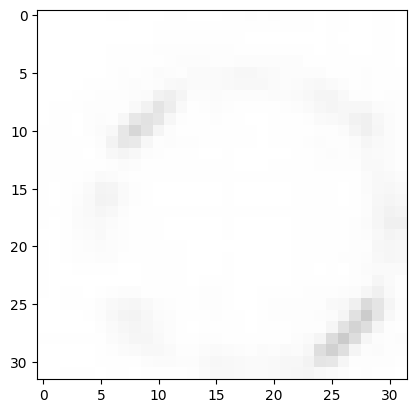

In [26]:
i = int(torch.rand(1) * 17000)
plt.imshow(train_img[i].permute(1,2,0))
print(train_label[i])

In [77]:
import os
image_folder = "/Users/phamminhtuan/Desktop/Trainning_SET/Images"
label_folder = "/Users/phamminhtuan/Downloads/Trainning_SET/Labels"
draw_label_folder = "/Users/phamminhtuan/Downloads/Trainning_SET/drawLabels"
for filename in os.listdir(image_folder):
    if filename.endswith('iter_2.jpg'):    
        image_path = os.path.join(image_folder, filename)
        label_path = os.path.join(label_folder, os.path.splitext(filename)[0] + ".txt")
        remove_duplicate_lines(label_path)
        remove_duplicates_column2_and_column3(label_path, label_path)
        temp = MyDataset(image_path=image_path,label_path=label_path)
        print(image_path)
        print(label_path)
        print(len(temp)) 
        image = cv2.imread(image_path)
        labels, coords = utils.read_file_to_tensors(label_path)
        for i, coord in enumerate(coords):
            x1, y1, x2, y2 = utils.find_yolov8_square(image, coord)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.imwrite(os.path.join(draw_label_folder, os.path.splitext(filename)[0] + ".jpg"), image)

Đã loại bỏ các dòng trùng lặp thành công.
Đã loại bỏ các dòng trùng lặp ở cột 2 và cột 3.
/Users/phamminhtuan/Desktop/Trainning_SET/Images/IMG_2269_iter_2.jpg
/Users/phamminhtuan/Downloads/Trainning_SET/Labels/IMG_2269_iter_2.txt
418
Đã loại bỏ các dòng trùng lặp thành công.
Đã loại bỏ các dòng trùng lặp ở cột 2 và cột 3.
/Users/phamminhtuan/Desktop/Trainning_SET/Images/IMG_1587_iter_2.jpg
/Users/phamminhtuan/Downloads/Trainning_SET/Labels/IMG_1587_iter_2.txt
572
Đã loại bỏ các dòng trùng lặp thành công.
Đã loại bỏ các dòng trùng lặp ở cột 2 và cột 3.
/Users/phamminhtuan/Desktop/Trainning_SET/Images/IMG_2270_iter_2.jpg
/Users/phamminhtuan/Downloads/Trainning_SET/Labels/IMG_2270_iter_2.txt
425
Đã loại bỏ các dòng trùng lặp thành công.
Đã loại bỏ các dòng trùng lặp ở cột 2 và cột 3.
/Users/phamminhtuan/Desktop/Trainning_SET/Images/IMG_1591_iter_2.jpg
/Users/phamminhtuan/Downloads/Trainning_SET/Labels/IMG_1591_iter_2.txt
572
Đã loại bỏ các dòng trùng lặp thành công.
Đã loại bỏ các dòng tr

# Test lại

In [75]:
import torch
import torch.nn as nn

def test_model(model, val_loader, device='cpu'):
    """
    Test the given model on the test dataset.

    Args:
        model (nn.Module): The trained model to evaluate.
        test_loader (DataLoader): A DataLoader for the test data.
        device (str, optional): The device to use for testing ('cpu' or 'cuda'). Defaults to 'cpu'.

    Returns:
        float: Test accuracy (in percentage).
        float: Test loss.
    """
    model = model.to(device)
    model.eval()  # Chuyển sang chế độ đánh giá
    criterion = nn.CrossEntropyLoss()

    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Tắt tính toán gradient để tăng tốc
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            labels = labels.long()
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    average_test_loss = test_loss / len(val_loader)

    print(f'Test Loss: {average_test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    return test_accuracy, average_test_loss


In [81]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EfficientCNN()
model.load_state_dict(torch.load('/Users/phamminhtuan/Desktop/AIChallenge/cnn.pth'))
model = model.to(device)

# Đánh giá mô hình
test_accuracy, test_loss = test_model(model, val_loader, device=device)

/var/folders/hv/wh1bzsb91mz5swh0znhrdrv00000gn/T/ipykernel_18657/1814793565.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/Users/pham

Test Loss: 0.0059
Test Accuracy: 99.88%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.7021082..1.0000001].


tensor([[-8.2792,  9.2511]], grad_fn=<AddmmBackward0>)
tensor(1.)


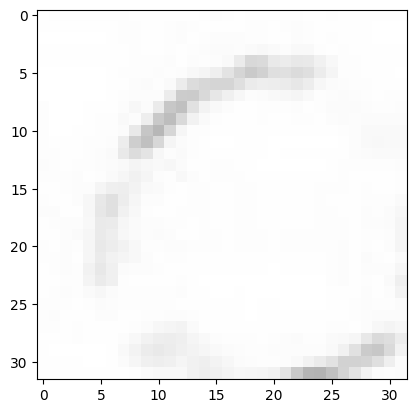

In [93]:
output = model(image.unsqueeze(0))
print(output)
print(test[0][1])
plt.imshow(image.permute(1,2,0))

In [103]:
image_path = "/Users/phamminhtuan/Desktop/Trainning_SET/Images/IMG_1587_iter_1.jpg"
label_path = "/Users/phamminhtuan/Desktop/Trainning_SET/Labels/IMG_1587_iter_1.txt"


In [105]:
import utils
import torchvision 
image = cv2.imread(image_path)
labels, coords = utils.read_file_to_tensors(label_path)
for i, coord in enumerate(coords):
    xy_coord = utils.find_yolov8_square(image, coord)
    x1, y1, x2, y2 = xy_coord
    input = utils.get_box(image, xy_coord)
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((32, 32))
        ])
    input = transform(input)
    output = model(input.unsqueeze(0))
    _, predicted = torch.max(output.data, 1)
    if (predicted == 1):
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
cv2.imwrite("/Users/phamminhtuan/Desktop/AIChallenge/avg_coords.jpg", image)

True